In [205]:
import torch
import random
from tqdm import tqdm
from diffusers import AutoencoderDC, SanaTransformer2DModel
from transformers import AutoModel, AutoTokenizer, set_seed
from utils import generate, generate_lms, make_grid, cifar10_labels

In [3]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

repo_transformer="g-ronimo/hana-alpha29"
repo_te = "answerdotai/ModernBERT-large"
repo_ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

transformer = SanaTransformer2DModel.from_pretrained(repo_transformer).to(device).to(dtype)
te = AutoModel.from_pretrained(repo_te, torch_dtype=dtype).to(device)
tok = AutoTokenizer.from_pretrained(repo_te, torch_dtype=dtype)
dcae = AutoencoderDC.from_pretrained(repo_ae, subfolder="vae", torch_dtype=dtype).to(device)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


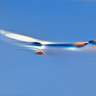

In [203]:
inference_config = dict(
    transformer=transformer,
    tokenizer=tok,
    text_encoder=te,
    dcae=dcae,
    num_steps=50,
    guidance_scale=5,
    latent_dim=[1, 32, 3, 3],
    # latent_seed = 123
)

prompt = "two airplanes in the sky"

generate(prompt, **inference_config)


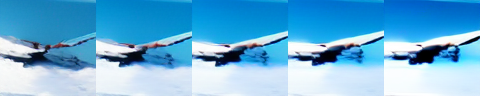

In [192]:
prompt = "an airplane in the sky"

make_grid([
    generate(prompt, guidance_scale=2, **inference_config),
    generate(prompt, guidance_scale=3, **inference_config),
    generate(prompt, guidance_scale=4, **inference_config),
    generate(prompt, guidance_scale=5, **inference_config),
    generate(prompt, guidance_scale=7, **inference_config),
])

100%|███████████████████████████████████████████| 10/10 [01:23<00:00,  8.34s/it]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


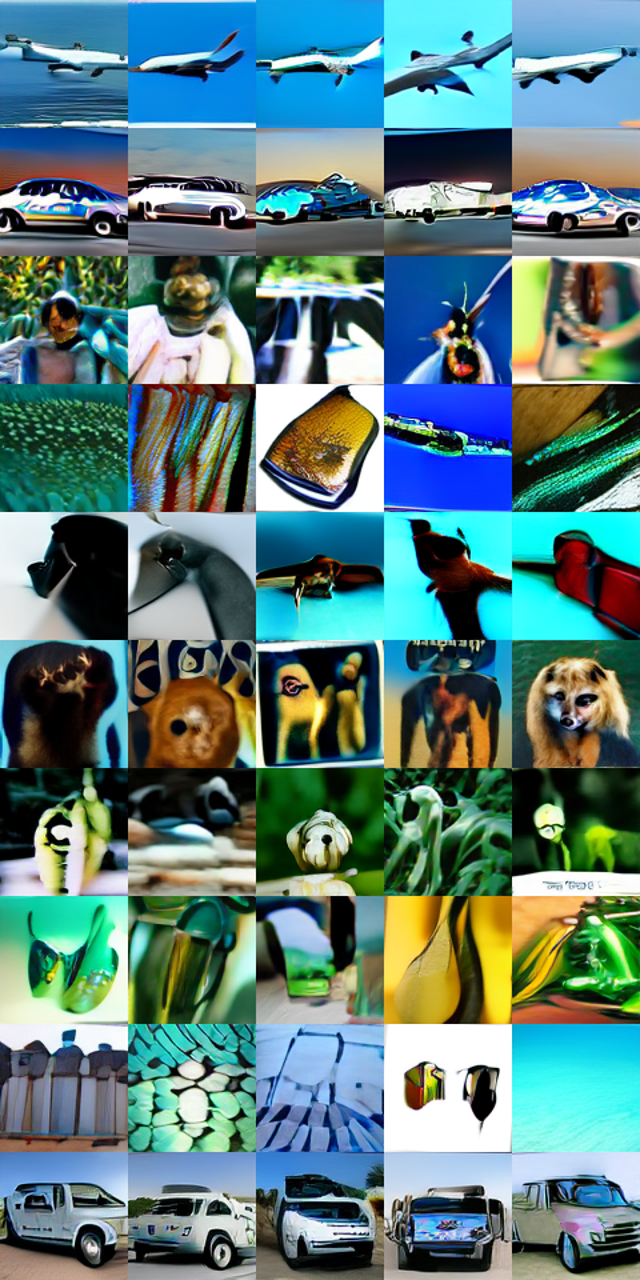

In [208]:
inference_config = dict(
    transformer=transformer,
    tokenizer=tok,
    text_encoder=te,
    dcae=dcae,
    num_steps=50,
    guidance_scale=5,
    latent_dim=[1, 32, 3, 3],
    # latent_seed = 123
)

labels = [cifar10_labels[k] for k in cifar10_labels]
num_imgs_per_label = 5

images = [
    generate(label, **inference_config)
    for label in tqdm(labels) for _ in range(num_imgs_per_label) 
]
print(labels)
make_grid(images, len(labels), num_imgs_per_label).resize((128*num_imgs_per_label, 128*len(labels)))